## COVID-19 Clinical Trial Phase Classification Using NLP

Data is transformed using Excel before loading 

### Importing libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from pylab import rcParams

from scipy import stats

from sklearn.preprocessing import LabelEncoder

In [5]:
%matplotlib inline
rcParams['figure.figsize'] = 10,6
sns.set_style('whitegrid')

### Loading the dataset

In [6]:
data = 'D:\\Teesside Uni\\Data Analyst\\Unified Mentor Projects\\COVID-19 Clinical Trails- EDA & ML\\Phase classification text data.xlsx'
df = pd.read_excel(data)

In [7]:
df

,Phase,text
0,Phase 2,study to evaluate the efficacy of covid190001u...
1,Phase 1,convalescent plasma for covid19 patients biolo...
2,Phase 3,covid19convalescent plasma for treating patien...
3,Phase 1,covid19 plasma in treatment of covid19 patient...
4,Phase 2,study evaluating the safety and efficacy of au...
...,...,...
1963,Phase 1,safety and immunogenicity of a nipah virus vac...
1964,Phase 1,evaluating the infectivity safety and immunoge...
1965,Phase 1,evaluation of safety tolerability and immune r...
1966,Phase 4,dynamics of the immune responses to repeat inf...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Phase   1968 non-null   object
 1   text    1968 non-null   object
dtypes: object(2)
memory usage: 30.9+ KB


After transforming the original data in Excel power query editor, now the new data has only two columns 'Phase' and 'text' and 1968 records.  

Column: Phase

In [9]:
df['Phase'].value_counts()

Phase
Phase 2    877
Phase 3    650
Phase 1    280
Phase 4    161
Name: count, dtype: int64

The number of Phase 2 & 3 are more than others, and this is expected and phase 4 is in minority class. This is because all the trials may not reach stage 4.

### Label Encoding

In [10]:
le = LabelEncoder()
df['phase_label'] = le.fit_transform(df['Phase'])

In [11]:
df[['Phase', 'phase_label']].drop_duplicates().sort_values('phase_label')

,Phase,phase_label
1,Phase 1,0
0,Phase 2,1
2,Phase 3,2
6,Phase 4,3


Encoded the categorical target variable into a numerical variable as above. 

### Feature and Traget variable

In [12]:
X= df['text']
y= df['phase_label']

### Model building

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)

stratification is very important as phases are not balanced and without stratify, the evaluation becomes misleading and unstable.

### TF-IDF Vectorization

Term Frequency-Inverse Document Frequency: the model cannot understand the text data. TF-IDF is used to convert the text into numbers.

converting text into numerical feature

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=5000, min_df=5,max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [15]:
X_train_tfidf.shape

(1574, 4119)

Now the text feature is numeric. X_train_tfidf is of 1574 trials and 4119 learned textual features. 

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Evaluation

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     Phase 1       0.40      0.62      0.49        56
     Phase 2       0.62      0.45      0.52       176
     Phase 3       0.52      0.56      0.54       130
     Phase 4       0.16      0.19      0.17        32

    accuracy                           0.49       394
   macro avg       0.43      0.46      0.43       394
weighted avg       0.52      0.49      0.50       394



                 recall  

     Phase 1      0.62     
     Phase 2      0.45      
     Phase 3      0.56      
     Phase 4      0.19     

Phase 1 trials have higher recall rate at 62%, which is 62% Phase 1 is correctly identified and phase 4 has the lowest recall, this could be because of insufficient data of phase 4.

In [18]:
print(confusion_matrix(y_test,y_pred))

[[35 10  8  3]
 [35 80 49 12]
 [12 29 73 16]
 [ 6 10 10  6]]


### Logistic Regression-Confusion matrix heatmap

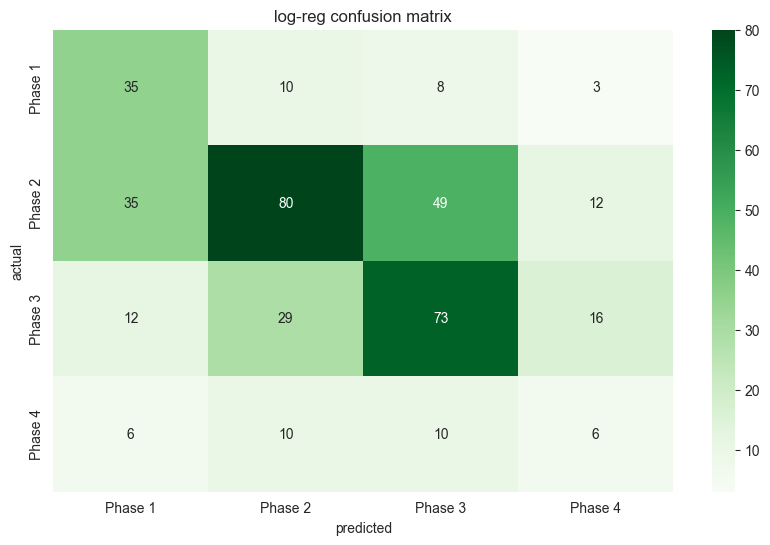

In [19]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('log-reg confusion matrix')
plt.savefig('log_reg_cm.png', dpi=500, bbox_inches='tight')
plt.show()

Phase 1 correctly predicted 35 keywords and misclassified few words.

Phase 2 correctly predicted 80 and misclassified 35 words as 1 and 49 as 3.

Phase 3 correctly predicted 73 and misclassified 29 as phase 2

Phase 4 predictly only 6 because of lack of data, but this was expected.

### Keywords from each Phase 1-4

In [20]:
model.coef_.shape

(4, 4119)

4= Phase rows

4119= features from TF-IDF

In [21]:
feature_names = np.array(tfidf.get_feature_names_out())

for i, phase in enumerate(le.classes_):
    top_features = np.argsort(model.coef_[i])[-15:]
    print(f"\nTop terms for {phase}:")
    print(feature_names[top_features])


Top terms for Phase 1:
['form' 'stress' 'mesenchymal' 'abnormal' 'cells' 'response' 'enhance'
 'vaccine' 'biological' 'in healthy' 'plasma' 'safety' 'tolerability'
 'healthy' 'adverse']

Top terms for Phase 2:
['study' 'measured' 'alive and' 'of pulmonary' 'tofacitinib' 'subjects'
 'to' 'ruxolitinib' 'type' 'with covid19' 'requiring' 'respiratory' 'on'
 'viral' 'placebo']

Top terms for Phase 3:
['at' 'covid19' 'and safety' 'during' 'days' 'among' 'hospital'
 'participants who' 'of the' 'allcause' 'of patients' 'standard'
 'symptomatic' 'or' 'efficacy']

Top terms for Phase 4:
['tablets' 'hydrogen' 'dosedrug' 'rivaroxaban' 'drug dexamethasone'
 'influenza' 'vaccination' 'ivig' 'combined' 'cases' 'after' 'drug'
 'coronavac' 'dexamethasone' 'nitazoxanide']


Above are the words, in which they strongly appear in the respective phases of the trial.

### Checking coef_

In [22]:
coef_df = pd.DataFrame(model.coef_, index=le.classes_, columns=feature_names)

coef_df 

,05,09,09 saline,10,100,11,11point,12,13,13 cis,...,worsening,worsening of,year,years,years and,years of,years old,zero,zero to,zinc
Phase 1,-0.235794,-0.041146,-0.037479,-0.383028,0.213067,-0.062072,0.059223,-0.263676,-0.118380,-0.076143,...,0.093592,-0.046525,-0.069976,-0.113666,0.055589,-0.010353,0.005356,0.020627,0.096326,-0.320722
Phase 2,0.065147,-0.054022,0.109535,0.144793,-0.207286,-0.047802,0.015296,0.187812,0.047508,0.095158,...,0.009710,0.174198,-0.006626,0.275912,0.073539,0.003223,-0.118347,0.101195,-0.051226,-0.076335
Phase 3,-0.206409,-0.217511,0.002925,0.035461,0.244686,0.186114,-0.000947,0.097949,0.168918,0.038224,...,0.106950,-0.062009,0.099649,0.051062,-0.053944,0.039709,0.181182,-0.040260,-0.009309,0.235789
Phase 4,0.377056,0.312679,-0.074981,0.202774,-0.250468,-0.076240,-0.073573,-0.022085,-0.098047,-0.057239,...,-0.210253,-0.065664,-0.023047,-0.213307,-0.075184,-0.032579,-0.068191,-0.081563,-0.035791,0.161267


In [23]:
coef_df.loc["Phase 2"].sort_values(ascending=False).head()

placebo        1.290812
viral          1.123194
on             1.033813
respiratory    0.851141
requiring      0.791435
Name: Phase 2, dtype: float64

In [24]:
coef_df.loc["Phase 2"].sort_values(ascending=True).head()

vaccine              -1.050176
dexamethasone        -0.892508
hydroxychloroquine   -0.877425
daily                -0.809367
in                   -0.807162
Name: Phase 2, dtype: float64

Phase 2:

Words like Placebo, viral increases the probability of the phase.

words vaccine, dexamethasone decreases the probability of the phase, because they are keywords which are mostly associated with later trial phases. It is already known that there is a misclassification of phase 2 keywords from phases 1 and 3.

### Adding class weights to phase 4: Improving recall

In [25]:
le.classes_

array(['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'], dtype=object)

Index of phase 4 is 3

In [26]:
new_weights = {0:1.0, 1:1.0, 2:1.0, 3:2.5} #adding more weight to phase 4

Above are the new weights in which phase 4(3) has more weightage than the other phases. Logistic regression model is trained again and eventually increases recall value of phase 4 without affecting the precision of other models much. 

In [27]:
model_new = LogisticRegression(max_iter=1000, class_weight=new_weights, n_jobs=1)

model_new.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: 1.0, 1: 1.0, 2: 1.0, 3: 2.5}"
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Evaluation with new weights

In [28]:
y_pred_new = model_new.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_new, target_names=le.classes_))

              precision    recall  f1-score   support

     Phase 1       0.89      0.30      0.45        56
     Phase 2       0.53      0.75      0.62       176
     Phase 3       0.49      0.43      0.46       130
     Phase 4       0.36      0.12      0.19        32

    accuracy                           0.53       394
   macro avg       0.57      0.40      0.43       394
weighted avg       0.55      0.53      0.51       394



With the new weights for phase 4, the recall dropped to 12% an previously with balanced weights it was 19%. Phase 4 is in small size with a few unique terms and shares it's terms with 

When class weights increased for phase 4, Logistic regression increased margin for phase 4 and adjusted coefficients to reduce phase 4 loss.

But phase 4 overlaps with phase 3, recall dropped. 

In [29]:
new_cm=confusion_matrix(y_test, y_pred_new)
new_cm

array([[ 17,  32,   7,   0],
       [  1, 132,  41,   2],
       [  0,  69,  56,   5],
       [  1,  17,  10,   4]])

### Comparision log_reg vs log_reg_new-weights

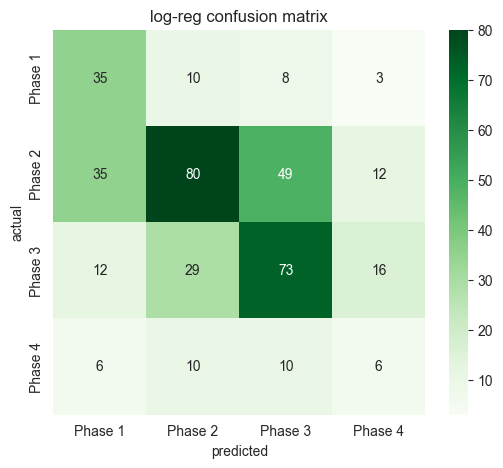

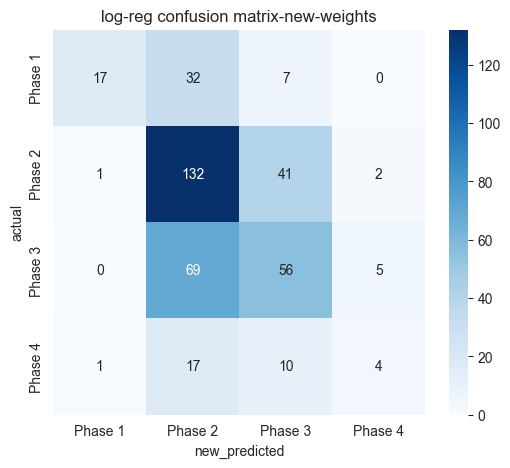

In [30]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('log-reg confusion matrix')
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(new_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('new_predicted')
plt.ylabel('actual')
plt.title('log-reg confusion matrix-new-weights')
plt.savefig('new_log_reg_cm.png', dpi=500, bbox_inches='tight')
plt.show()

Above is the confusion matrix with the added phase 4 weights=2.5. The reason for adding more weight only to phase 4 to increase the recall value by penalizing misclassification of phase 4. so that model predicts phase 4 more often. 

But that didn't work at all. As the recall dropped and now it only predicts 4 keywords which is less than before.

The predictions for phase 3 dropped.

The predictions for phase 2 increased as it is taking all the misclassifications from phase 3, phase 1, phase 2.

It can be concluded that logistic regression had done it's best.


### Linear Support Vector Machine

In [31]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight='balanced', C=1.0, max_iter=5000)
svm_model.fit(X_train_tfidf,y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


### Evaluation-Linear SVM

In [32]:
y_pred_svm = svm_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

              precision    recall  f1-score   support

     Phase 1       0.52      0.54      0.53        56
     Phase 2       0.57      0.58      0.57       176
     Phase 3       0.49      0.52      0.50       130
     Phase 4       0.24      0.16      0.19        32

    accuracy                           0.52       394
   macro avg       0.45      0.45      0.45       394
weighted avg       0.51      0.52      0.51       394



Recall still did not improve for Phase 4.

In [33]:
svm_cm = confusion_matrix(y_test, y_pred_svm)
svm_cm

array([[ 30,  17,   8,   1],
       [ 18, 102,  50,   6],
       [  7,  47,  67,   9],
       [  3,  13,  11,   5]])

### Comparision log_reg vs svm confusion matrix

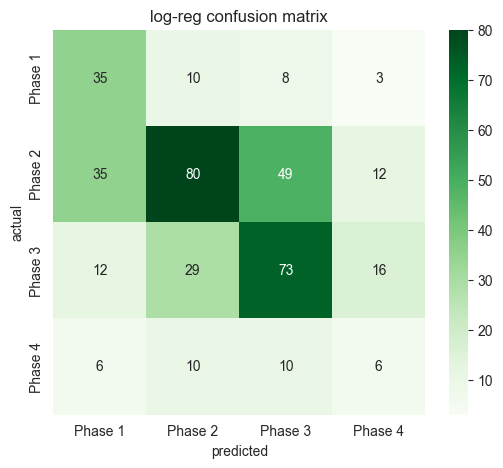

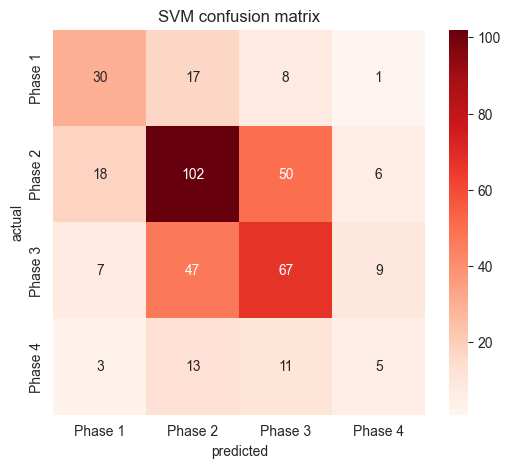

In [34]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('log-reg confusion matrix')
plt.show()


plt.figure(figsize=(6,5))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('SVM confusion matrix')
plt.savefig('svm_cm.png', dpi=500, bbox_inches='tight')
plt.show()

Recall value of Phase 4 from Linear-SVM model is 16%, which is less than the original logistic regression recall value. So,Linear-SVM did not improve the phase 4 recall value.

Improvements:

Phase 3: Although recall dropped for phase 3, errors of phase 3-> phase 4 decreased from 16 to 9.

Only fewer phase 3 samples collapsed into phase 2. 


Phase 2: Before with Log_reg, the correct predictions were 80, but they are 102, in which SVM did better considering the samples Phase 2 has intially.

Phase 1: Recall dropped, but errors also dropped from phase 1--> phase 3 i.e; from 12 to 7.

So, both Logistic regression and Linear SVM models failed to improve phase 4 recall and this is because data scarcity.

### Hierarchical Classification

#### Level-1

As the models, logistic regression and linear SVM are not that great. It is better a hierarchy design where

Early = Phase 1, Phase 2

Late = Phase 3, Phase 4

In [36]:
df['stage'] = df['Phase'].apply(lambda x: 'Early' if x in ['Phase 1', 'Phase 2'] else 'Late')

In [39]:
df['stage'].value_counts()

stage
Early    1157
Late      811
Name: count, dtype: int64

So, now there are only 2 phases which are Early & Late with the new feature 'stage'

### Train-test-split

In [40]:
X_train, X_test, y_stage_train, y_stage_test = train_test_split(df['text'], df['stage'], test_size=0.2, random_state=42, stratify=df['stage'])

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_stage_train.shape)
print(y_stage_test.shape)

(1574,)
(394,)
(1574,)
(394,)


In [41]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Linear SVM Model (Early & Late)

In [43]:
stage_svm_model = LinearSVC(class_weight='balanced', C=1.0, max_iter=5000)
stage_svm_model.fit(X_train_tfidf,y_stage_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [45]:
y_pred_stage_svm = stage_svm_model.predict(X_test_tfidf)

### Evaluation - Linear SVM (Early & Late)

In [ ]:
print(classification_report(y_stage_test, y_pred_stage_svm, target_names=['Early','Late']))

              precision    recall  f1-score   support

       Early       0.76      0.72      0.74       232
        Late       0.63      0.67      0.65       162

    accuracy                           0.70       394
   macro avg       0.69      0.70      0.69       394
weighted avg       0.70      0.70      0.70       394



Late recall : 67%, so in the late stage trials 33% are being misclassified as early at Level 1 of the hierarchy.

But in a hierarchy, at a level-1 if a late stage trial is misclassified as early stage, it will reach level-2 i.e; phase 3 vs phase 4 classifier and phase 4 recall will completely lost. So, level-1 must over protect late stage.  

In [47]:
svm_stage_cm=confusion_matrix(y_stage_test, y_pred_stage_svm)
svm_stage_cm

array([[168,  64],
       [ 54, 108]])

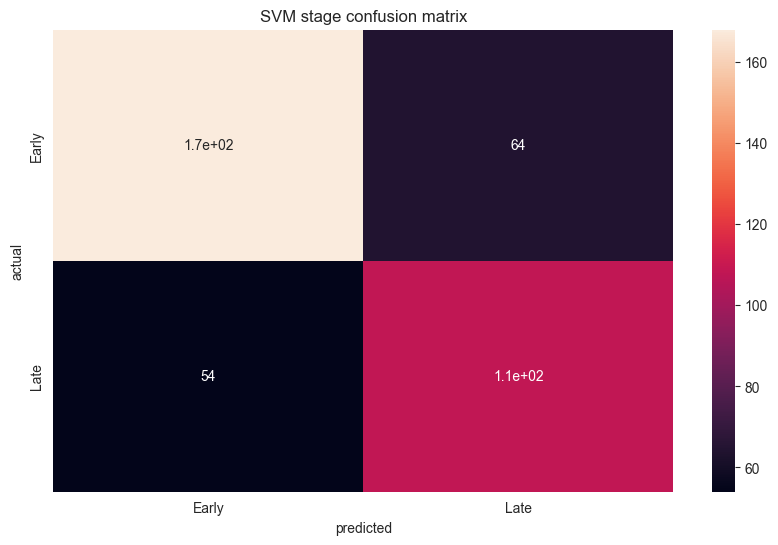

In [53]:
sns.heatmap(svm_stage_cm, annot=True, xticklabels=['Early','Late'], yticklabels=['Early','Late'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('SVM stage confusion matrix')
plt.savefig('svm_stage_cm.png', dpi=500, bbox_inches='tight')
plt.show()

To jump to level-2 of hierarchy, the recall of early should be approx 60% and for the late it should be approx 80%

### Level-1 adding weights towards late stage {2.0 - 4.0 }

In [72]:
stage_svm_w = LinearSVC(class_weight={'Early':1.0,'Late':3.0}, C=1.0, max_iter=5000)

stage_svm_w.fit(X_train_tfidf, y_stage_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{'Early': 1.0, 'Late': 3.0}"
,verbose,0
,random_state,None


In [73]:
y_pred_stage_svm_w = stage_svm_w.predict(X_test_tfidf)

In [74]:
print(classification_report(y_stage_test, y_pred_stage_svm_w, target_names=['Early','Late']))

              precision    recall  f1-score   support

       Early       0.78      0.62      0.69       232
        Late       0.58      0.75      0.65       162

    accuracy                           0.68       394
   macro avg       0.68      0.69      0.67       394
weighted avg       0.70      0.68      0.68       394



I have added weight for the late stage from 2.0 to 4.0 but the recall doesn't go past 75%. So TF-IDF text feature is not able to classify early and late stage trials. So continuing hierarchical classification is not a good option as it is not possible to move to level-2.

### Conclusion

In this project, I was predicting COVID-19 clinical trial phases using text data. Starting with TF-IDF, I evaluated multiple linear classifiers including Logistic Regression and Linear SVM. Detailed analysis of confusion matrices and model coefficients showed that there were misclassifications occuring in different phases of the trial.

Despite applying class weighting, switching classifiers, and reformulating the task as hierarchical classification, model performance particularly recall for late-stage (Phase 4) trials consistently stayed the same. Further investigaion revealed that this limitation is in the clinical trial text data.

The key outcome: text only TF-IDF features are insufficient to really classify the exact clinical trial phase, especially in late (phase 3, phase 4) stages. This finding highlights the importance of feature representation and problem formulation in applied machine learning and motivates future work incorporating structured metadata or contextual embeddings.

